# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Descripción-del-problema-a-resolver" data-toc-modified-id="Descripción-del-problema-a-resolver-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Descripción del problema a resolver</a></div><div class="lev1 toc-item"><a href="#Breve-introducción-a-la-GE" data-toc-modified-id="Breve-introducción-a-la-GE-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Breve introducción a la GE</a></div><div class="lev1 toc-item"><a href="#Método-para-resolverlo" data-toc-modified-id="Método-para-resolverlo-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Método para resolverlo</a></div><div class="lev2 toc-item"><a href="#Idoneidad-de-GE-para-resolver-el-problema" data-toc-modified-id="Idoneidad-de-GE-para-resolver-el-problema-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Idoneidad de GE para resolver el problema</a></div><div class="lev2 toc-item"><a href="#Expresión-matemática-de-la-función-de-evaluación" data-toc-modified-id="Expresión-matemática-de-la-función-de-evaluación-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Expresión matemática de la función de evaluación</a></div><div class="lev2 toc-item"><a href="#Operadores-de-inicialización,-variación-y-selección" data-toc-modified-id="Operadores-de-inicialización,-variación-y-selección-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Operadores de inicialización, variación y selección</a></div><div class="lev2 toc-item"><a href="#Implementación-del-algoritmo-principal" data-toc-modified-id="Implementación-del-algoritmo-principal-34"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Implementación del algoritmo principal</a></div><div class="lev2 toc-item"><a href="#Parametrización" data-toc-modified-id="Parametrización-35"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Parametrización</a></div><div class="lev2 toc-item"><a href="#Manejo-de-restricciones-y-mecanismos-de-control-de-parámetros-adaptativos-o-auto-adaptativos" data-toc-modified-id="Manejo-de-restricciones-y-mecanismos-de-control-de-parámetros-adaptativos-o-auto-adaptativos-36"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Manejo de restricciones y mecanismos de control de parámetros adaptativos o auto-adaptativos</a></div><div class="lev1 toc-item"><a href="#Utilidades-de-interpretación-de-resultados" data-toc-modified-id="Utilidades-de-interpretación-de-resultados-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Utilidades de interpretación de resultados</a></div><div class="lev2 toc-item"><a href="#Plots-de-progreso-en-escala-logarítmica" data-toc-modified-id="Plots-de-progreso-en-escala-logarítmica-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Plots de progreso en escala logarítmica</a></div><div class="lev2 toc-item"><a href="#Índices-SR,-MBF-y-AES" data-toc-modified-id="Índices-SR,-MBF-y-AES-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Índices SR, MBF y AES</a></div><div class="lev1 toc-item"><a href="#Los-7-problemas" data-toc-modified-id="Los-7-problemas-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Los 7 problemas</a></div><div class="lev1 toc-item"><a href="#Justificación-de-la-selección-de-parámetros" data-toc-modified-id="Justificación-de-la-selección-de-parámetros-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Justificación de la selección de parámetros</a></div><div class="lev2 toc-item"><a href="#MAX_WRAPS:-aumentar-vs-no-aumentar" data-toc-modified-id="MAX_WRAPS:-aumentar-vs-no-aumentar-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>MAX_WRAPS: aumentar vs no aumentar</a></div><div class="lev2 toc-item"><a href="#CODON_SIZE:-aumentar-vs-no-aumentar" data-toc-modified-id="CODON_SIZE:-aumentar-vs-no-aumentar-62"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>CODON_SIZE: aumentar vs no aumentar</a></div><div class="lev2 toc-item"><a href="#INITIAL_IND_LENGTH:-aumentar-vs-no-aumentar" data-toc-modified-id="INITIAL_IND_LENGTH:-aumentar-vs-no-aumentar-63"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>INITIAL_IND_LENGTH: aumentar vs no aumentar</a></div><div class="lev2 toc-item"><a href="#EVAL_PENALTY:-disminuir-vs-no-disminuir" data-toc-modified-id="EVAL_PENALTY:-disminuir-vs-no-disminuir-64"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>EVAL_PENALTY: disminuir vs no disminuir</a></div><div class="lev2 toc-item"><a href="#UNDECODABLE_PENALTY:-disminuir-vs-no-disminuir" data-toc-modified-id="UNDECODABLE_PENALTY:-disminuir-vs-no-disminuir-65"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>UNDECODABLE_PENALTY: disminuir vs no disminuir</a></div><div class="lev2 toc-item"><a href="#POPULATION_SIZE:-aumentar-vs-no-aumentar" data-toc-modified-id="POPULATION_SIZE:-aumentar-vs-no-aumentar-66"><span class="toc-item-num">6.6&nbsp;&nbsp;</span>POPULATION_SIZE: aumentar vs no aumentar</a></div><div class="lev2 toc-item"><a href="#GENERATION_SIZE:-aumentar-vs-no-aumentar" data-toc-modified-id="GENERATION_SIZE:-aumentar-vs-no-aumentar-67"><span class="toc-item-num">6.7&nbsp;&nbsp;</span>GENERATION_SIZE: aumentar vs no aumentar</a></div><div class="lev2 toc-item"><a href="#MUTATION_PROBABILITY:-aumentar-vs-no-aumentar" data-toc-modified-id="MUTATION_PROBABILITY:-aumentar-vs-no-aumentar-68"><span class="toc-item-num">6.8&nbsp;&nbsp;</span>MUTATION_PROBABILITY: aumentar vs no aumentar</a></div><div class="lev2 toc-item"><a href="#CROSSOVER_PROBABILITY:-aumentar-vs-no-aumentar" data-toc-modified-id="CROSSOVER_PROBABILITY:-aumentar-vs-no-aumentar-69"><span class="toc-item-num">6.9&nbsp;&nbsp;</span>CROSSOVER_PROBABILITY: aumentar vs no aumentar</a></div><div class="lev2 toc-item"><a href="#WITHIN_USED:-True-vs-False" data-toc-modified-id="WITHIN_USED:-True-vs-False-610"><span class="toc-item-num">6.10&nbsp;&nbsp;</span>WITHIN_USED: True vs False</a></div><div class="lev2 toc-item"><a href="#TOURNAMENT_SIZE:-aumentar-vs-no-aumentar¶" data-toc-modified-id="TOURNAMENT_SIZE:-aumentar-vs-no-aumentar¶-611"><span class="toc-item-num">6.11&nbsp;&nbsp;</span>TOURNAMENT_SIZE: aumentar vs no aumentar¶</a></div><div class="lev2 toc-item"><a href="#ELITE_SIZE:-aumentar-vs-no-aumentar¶" data-toc-modified-id="ELITE_SIZE:-aumentar-vs-no-aumentar¶-612"><span class="toc-item-num">6.12&nbsp;&nbsp;</span>ELITE_SIZE: aumentar vs no aumentar¶</a></div><div class="lev2 toc-item"><a href="#Comparación-de-resultados-y-selección-final-de-parámetros" data-toc-modified-id="Comparación-de-resultados-y-selección-final-de-parámetros-613"><span class="toc-item-num">6.13&nbsp;&nbsp;</span>Comparación de resultados y selección final de parámetros</a></div><div class="lev1 toc-item"><a href="#Ejecución-con-la-configuración-&quot;óptima&quot;-en-los-7-problemas" data-toc-modified-id="Ejecución-con-la-configuración-&quot;óptima&quot;-en-los-7-problemas-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Ejecución con la configuración "óptima" en los 7 problemas</a></div><div class="lev1 toc-item"><a href="#Soluciones-encontradas" data-toc-modified-id="Soluciones-encontradas-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Soluciones encontradas</a></div><div class="lev1 toc-item"><a href="#Representación-de-las-soluciones-encontradas-y-las-esperadas" data-toc-modified-id="Representación-de-las-soluciones-encontradas-y-las-esperadas-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Representación de las soluciones encontradas y las esperadas</a></div>

# Descripción del problema a resolver

Remitiéndome a las indicaciones dadas en el documento de la actividad, el problema consiste en implementar un algoritmo evolutivo para calcular la derivada simbólica de una función 
$$ f:X \subseteq \mathcal{R} \rightarrow \mathcal{R} $$ 

Disponemos de las siguientes dos definiciones:

> **Definición de derivada de una función en un punto**: Sea $X \subseteq \mathcal{R}$ un intervalo abierto. Diremos que $f:X \subseteq \mathcal{R} \rightarrow \mathcal{R}$ es derivable en $x_0 \in X$, denotado por $f'(x_0)$, si existe y es finito el límite:
$$
f'(x_0) = \lim \limits_{h \to 0} \frac{f(x_0+h)-f(x_0)}{h}  \tag{1}
$$

> **Definición de derivada de una función en un intervalo**: Sea $X \subseteq \mathcal{R}$ un intervalo abierto. Diremos que $f:X \subseteq \mathcal{R} \rightarrow \mathcal{R}$ es derivable en el intervalo $[a,b] \subseteq X$, si $f$ es derivable en cada uno de los puntos de dicho intervalo, es decir, si:
$$
f'(x) = \lim \limits_{h \to 0} \frac{f(x+h)-f(x)}{h}, \forall x \in [a,b]  \tag{2}
$$

Suponiendo que $f$ sea derivable en $[a,b]$, el problema de calcular la derivada lo vamos a transformar en un nuevo problema de optimización consistente en encontrar una función $g(x)$ que minimice la expresión:
$$
\min \limits_{g(x)} \frac{1}{b-a}\int_{a}^{b} error[f'(x),g(x)]dx \tag{3}
$$

dónde $f'(x)$ se calcularía utilizando la expresión $(2)$.

No obstante, el problema anterior se puede resolver de forma aproximada discretizando el intervalo de definición, es decir, cambiando el operador integral por un sumatorio:
$$
\min \limits_{g(x)} \frac{1}{N+1}\sum_{i=0}^{N} error_i[f'(a+i*h),g(a+i*h)] \tag{4}
$$
dónde $h=\frac{b-a}{N}$ es la anchura del subintervalo de muestreo para conseguir muestrear $N+1$ puntos en el intervalo $[a,b]$, y $f'(a+i*h)$ viene dado por:
$$
f'(a+i*h)=\frac{f(a+(i+1)*h) - f(a+i*h)}{h}, \forall i \in \{0,1,...,N\} \tag{5}
$$

# Breve introducción a la GE

La evolución gramatical codifica un conjunto de números pseudo aleatorios **(codones)** en un cromosoma que consiste en un número variable de genes binarios de 8 bits. 

Estos números se usan para seleccionar una regla apropiada a partir de una definición de gramática con **notación Backus-Naur (BNF)**.

**Una gramática de BNF consiste en la tupla**
$$  \{N, T, P, S \} $$
dónde:

- **N** es el conjunto de no terminales, 
- **T** es el conjunto de terminales
- **P** es un conjunto de reglas de producción que mapean los elementos de N a T 
- **S** es un símbolo de inicio que es un miembro de N. 
  
Los no terminales de la gramática se mapean en los terminales de la gramática mediante la aplicación recursiva de las reglas dictadas por los valores de los genes. Al finalizar el proceso de mapeo, el código final producido (fenotipo) está formado sólo por terminales.

Por ejemplo, si consideramos esta gramática BNF:

```
N = { expr, op, pre_op } 
T = { Sin, Cos, Tan, Log, +, -, /, *, X, () } 
S = <expr>
```

Y representamos P por:

```
(1) <expr> ::= <expr> <op> <expr>     (A) 
             | ( <expr> <op> <expr> ) (B)
             | <pre-op> ( <expr> )    (C) 
             | <var>                  (D)
(2) <op> ::= + (A)  
           | - (B) 
           | / (C) 
           | * (D)
(3) <pre-op> ::= Sin (A)  
               | Cos (B) 
               | Tan (C) 
               | Log (D)
(4) <var> ::= X
```

Consideremos la regla (1):

```
(1) <expr> ::= <expr> <op> <expr> 
             | ( <expr> <op> <expr> ) 
             | <pre-op> ( <expr> ) 
             | <var>
```

En este caso, el no terminal puede producir uno de cuatro resultados diferentes, para decidir cuál utilizar nuestro sistema toma el siguiente número aleatorio disponible del cromosoma y, en este caso obtiene el módulo cuatro del número para decidir qué regal de producción toma. 

Cada vez que se tiene que tomar una decisión, se lee otro número pseudo aleatorio del cromosoma, y de esta manera, el sistema atraviesa el cromosoma.

En GE es posible que los individuos se queden sin genes durante el proceso de mapeo, y en este caso hay dos alternativas:
- La primera es declarar al individuo inválido y castigarlos con un valor de fitness adecuado
- La segunda es envolver al individuo y reutilizar los genes. Este es un enfoque bastante inusual en EAs, ya que es completamente posible que ciertos genes se usen dos o más veces. 

**Lo que es crucial, sin embargo, es que cada vez que un individuo en particular es mapeado de su genotipo a su fenotipo, se genera la misma salida. Esto se garantiza por el proceso de mapeo descrito anteriormente.**


#  Método para resolverlo

## Idoneidad de GE para resolver el problema

Nuestro problema consiste en encontrar la derivada de una función probando/evolucionando distintas combinaciones de otras dadas.

Según leemos en [grammatical-evolution.org](http://www.grammatical-evolution.org/papers/gp98/node1.html): 

> *GE has proved successful when applied to a symbolic regression problem [Ryan 98a], and finding trigonometric identities [Ryan 98b], here we apply GE to a symbolic integration problem taken from the literature [Koza 92]. This involves finding a function which is an integral of Cos(X)+2X+1. In each of these cases we take a subset of C as our target language which is described in Backus Naur Form definition. A Steady State selection mechanism [Syswerda 89] has been employed and was found to reduce the number of generations required to achieve a correct solution. Using this selection mechanism we reapplied our system to the two problems previously tackled and again found an improvement in performance for both of these problems.*

Por lo tanto, según esta referencia, parece que utilizar una técnica evolutiva basada en Evolución Gramatical podría ser la forma más indicada.

Además, teniendo en cuenta que el fundamente de la evolución gramatical se basa en definir una gramática que representa las formas válidas que pueden adoptar los individuos, y teniendo en cuenta que una función objetivo puede alcanzarse como combinación de operadores, números y otras funciones básicas, parece bastante natural que el problema de encontrar la derivadda de una función pueda abordar con técnicas de GE.

## Expresión matemática de la función de evaluación

Primero necesitamos una función que nos permita evaluar en $N$ puntos del intervalo de definición $D=[a,b]$ de una función $f$ cómo de bien queda aproximada la derivada de $f$ por una función $g$ que a la postre será el fenotipo de un individuo generado por los procesos evolutivos que se implementan más tarde en esta práctica.

In [1]:
% matplotlib inline

from math import sin, cos, exp, log
import numpy as np
import matplotlib.pyplot as plt

np.seterr(all='ignore')


def F(f, g, D, N=50, U=1e-1, K_0=1., K_1=10., EVAL_PENALTY=1e6):
    """
    Función de evaluación.
    """
    a, b = D
    h = float(b - a) / N
    cum_error = 0.
    hitting = True
    for x in np.arange(a, b, h):
        delta = 1e-3
        try:
            e = abs((f(x + delta) - f(x)) / delta - g(x))
        except:
            e = EVAL_PENALTY
        if e <= U:
            w = K_0
        else:
            w = K_1
            hitting = False
        cum_error += (w * e)

    return hitting, cum_error / (N + 1)


# F(sin,cos,[-2,2])

Siguiendo las indicaciones del enunciado de la práctica, en lugar de implementar desde cero el código que interpretase la gramática y realizara la decodificación de los individuos, prefiero apoyarme en una librería ya existante, [ponyge](https://github.com/jmmcd/ponyge). 

De ésta extraigo sólo la funcionalidad que permite interpretar la gramática y decodificar un individuo. No utilizo la librería tal cuál está disponible en la red, sino que me quedo sólo con la parte relevante, la cual incluyo en el archivo python ponyge.py. De este modo, puedo tener un objecto que interprete una gramática dada con una simple llamada:

In [22]:
from ponyge import Grammar

G = Grammar(
    """<expr>   ::= <expr><op><expr> \
                  | (<expr><op><expr>) \
                  | <pre_op>(<expr>) \
                  | <var>
       <op>     ::= + | - | * | / 
       <pre_op> ::= sin | cos | exp | log
       <var>    ::= x | 1.0
    """,
    MAX_WRAPS=0)

Y puedo obtener el fenotipo de un individuo cualquiera llamando al método **generate** del objeto que contiene la gramática. Nótese que el método generate devuelve:

- el fenotipo del individuo de entrada si puede ser decodificado según la gramática. None en otro caso
- el número de codones que se necesitan para la decodificación

No todos los codones se corresponden con individuos que puedan ser decodificados según la gramática, según se ve en el siguiente experimento:

In [23]:
i = 0
while True:
    i += 1
    genome = [np.random.randint(0, 10) for _ in range(5)]
    fen = G.generate(genome)
    if fen[0]:
        print fen, 'generated in %s rounds' % i
        break

('1.0', 2) generated in 6 rounds


## Operadores de inicialización, variación y selección

Para gestionar cómodamente los individuos utilizo la clase Individual. Esta clase contiene el genoma del individuo. Llamando al método **evaluate** con una gramática y una función fitness, se calcula el fenotipo, el fenotipo compilado (función lista para ser usada) y el fitness del individuo.

In [24]:
import random
from functools import partial


class Individual(object):
    """Clase que representa los individuos"""

    def __init__(self, codon_size, genome=None, LENGTH=100):
        if genome == None:
            self.genome = [
                random.randint(0, codon_size) for _ in range(LENGTH)
            ]
        else:
            self.genome = genome
        self.phenotype = None
        self.used_codons = 0
        self.compiled_phenotype = None
        self.fitness = 1e10
        self.codon_size = codon_size

    def __lt__(self, other):
        return self.fitness < other.fitness

    def __str__(self):
        return 'Individual: ' + str(self.phenotype) + ';' \
                '\t' + str(self.hitting) + ';' \
                '\t' + str(self.fitness)

    def generate(self, G):
        self.phenotype, self.used_codons = G.generate(self.genome)
        return self.phenotype, self.used_codons

    def evaluate(self, G, fitness_f, UNDECODABLE_PENALTY=1e6):
        """La función fitness_f admite como único 
        parámetro el fenotipo compilado
        """
        self.generate(G)
        if self.phenotype is None:
            self.hitting, self.fitness = False, UNDECODABLE_PENALTY
        else:
            a, b = fitness_f(eval('lambda x:' + self.phenotype))
            self.hitting, self.fitness = a, b

Para la **selección**, la podemos hacer por torneo:

In [25]:
def tournament_selection(population, GENERATION_SIZE, TOURNAMENT_SIZE=3):
    """Selecciona por torneo."""
    winners = []
    while len(winners) < GENERATION_SIZE:
        competitors = random.sample(population, TOURNAMENT_SIZE)
        competitors.sort()
        winners.append(competitors[0])
    return winners

**Las mutaciones las realizo a nivel de codón**, no de bit, permitiendo que se parametrice la probabilidad de mutación. Nótese que garantizo que el individuo resultado de una mutación siempre es un individuo válido según la gramática considerada. De este modo, según mis experimentos consigo mejores resultados.

In [26]:
def mutate(ind, G, MUTATION_PROBABILITY=.0):
    """Muta un individuo a nivel de codón con
    probabilidad MUTATION_PROBABILITY."""
    for i in range(min(ind.used_codons, len(ind.genome))):
        if random.random() < MUTATION_PROBABILITY:
            gen = ind.genome[i]
            vals = range(ind.codon_size)
            np.random.shuffle(vals)
            for j in vals:
                ind.genome[i] = j
                if ind.generate(G)[0] is not None:
                    break
                else:
                    ind.genome[i] = gen
    return ind

Y **el cruce lo realizo por un único punto**. Conviene observar que permito parametrizar que el cruce se realize o no por partes del genoma que pertenecen a la sección del mismo que es relevante en su decodificación. Igualmente, la probabilidad de que se produzca el cruze o no (que se devuelvan clones de los padres) es también parametrizable.

**En algoritmo principal que gobierna la evolución, me garantizo de que sólo individuos válidos según la gramática que se considera son utilizados tras la operación de cruce.**

In [27]:
def onepoint_crossover(p_0, p_1, CROSSOVER_PROBABILITY=.1, 
                       WITHIN_USED=True):
    """Dados dos individuos, crea un hijo cruzándolos
    por punto único. Si WITHIN_USED es True, el cruce
    se produce por partes del genoma usadas en la 
    decodificación de los padres"""
    c_p_0, c_p_1 = p_0.genome, p_1.genome
    if WITHIN_USED:
        max_p_0, max_p_1 = p_0.used_codons, p_1.used_codons
    else:
        max_p_0, max_p_1 = len(c_p_0), len(c_p_1)

    pt_p_0 = random.randint(1, max_p_0)
    pt_p_1 = random.randint(1, max_p_1)
    if random.random() < CROSSOVER_PROBABILITY:
        c_0 = c_p_0[:pt_p_0] + c_p_1[pt_p_1:]
        c_1 = c_p_1[:pt_p_1] + c_p_0[pt_p_0:]
    else:
        c_0, c_1 = c_p_0[:], c_p_1[:]

    ind_0 = Individual(p_0.codon_size, genome=c_0)
    ind_1 = Individual(p_1.codon_size, genome=c_1)
    return ind_0, ind_1 

Y por último, el método de **reemplazo, generacional con elitismo 2 por defecto,** aunque es configurable:

In [28]:
import copy


def generational_replacement(new_pop, pop, GENERATION_SIZE,
                             ELITE_SIZE=2):
    """Devuelve la nueva población a partir 
    de la actual y la anterior aplicando elitismo"""
    pop.sort()
    for ind in pop[:ELITE_SIZE]:
        new_pop.append(copy.copy(ind))
    new_pop.sort()
    return new_pop[:GENERATION_SIZE]

## Implementación del algoritmo principal

Por último, podemos implementar, con todas las funcionalidades anteriores, el algoritmo que gobernará nuestro programa de evolución gramátical.

In [29]:
def live(f, D, config):
    """Ejecuta el programa de evolución gramatical
    Args:
        - f: la función cuya derivada buscamos
        - D: el intervalo de definición de f
        - config: la configuración del algoritmo
    Devuelve el histórico de mejores individuos 
    por generación.
    """

    N = config['N']
    GRAMMAR = config['GRAMMAR']
    MAX_WRAPS = config['MAX_WRAPS']
    CODON_SIZE = config['CODON_SIZE']
    INITIAL_IND_LENGTH = config['INITIAL_IND_LENGTH']    
    EVAL_PENALTY = config['EVAL_PENALTY']
    UNDECODABLE_PENALTY = config['UNDECODABLE_PENALTY']
    U = config['U']
    K_0 = config['K_0']
    K_1 = config['K_1']       
    POPULATION_SIZE = config['POPULATION_SIZE']
    GENERATION_SIZE = config['GENERATION_SIZE']
    MAX_GENERATIONS = config['MAX_GENERATIONS']
    MUTATION_PROBABILITY = config['MUTATION_PROBABILITY']
    CROSSOVER_PROBABILITY = config['CROSSOVER_PROBABILITY']
    WITHIN_USED = config['WITHIN_USED']
    TOURNAMENT_SIZE = config['TOURNAMENT_SIZE']
    ELITE_SIZE = config['ELITE_SIZE']

    # Definimos la gramática
    G = Grammar(GRAMMAR, MAX_WRAPS)
    
    # y la función fitness
    def fitness_F(fen):
        return F(f, fen, D, N=N, U=U, K_0=K_0, K_1=K_1, 
                 EVAL_PENALTY=EVAL_PENALTY)

    # Población inicial (válida)
    population = []
    while len(population) < POPULATION_SIZE:
        ind = Individual(CODON_SIZE,LENGTH=INITIAL_IND_LENGTH)
        if ind.generate(G)[0] is not None:
            population.append(ind)

    # Evaluamos la población inicial
    for ind in population:
        ind.evaluate(G, fitness_F, 
                     UNDECODABLE_PENALTY=UNDECODABLE_PENALTY)

    population.sort()
    best = population[0]
    history = [best]

    generation = 0
    while generation < MAX_GENERATIONS and not best.hitting:
        
        # Seleccionamos los padres
        parents = tournament_selection(
            population, GENERATION_SIZE, 
            TOURNAMENT_SIZE=TOURNAMENT_SIZE)

        # Cruzamos los padres -> nueva población
        new_population = []
        while len(new_population) < GENERATION_SIZE:
            A, B = random.sample(parents, 2)
            C_1, C_2 = onepoint_crossover(A, B,
                CROSSOVER_PROBABILITY=CROSSOVER_PROBABILITY,
                WITHIN_USED=WITHIN_USED)
            # Solo admitimos si algun individuo es válido
            if C_1.generate(G)[0] is not None:
                new_population.extend([C_1])
            if C_2.generate(G)[0] is not None:
                new_population.extend([C_2])
            
    
        # Mutamos la nueva población
        for ind in new_population:
            mutate(ind, G, 
                   MUTATION_PROBABILITY=MUTATION_PROBABILITY)

        # Evaluamos el fitness de la nueva población
        for ind in new_population:
            ind.evaluate(G, fitness_F, 
                         UNDECODABLE_PENALTY=UNDECODABLE_PENALTY)

        # Procedemos al reemplazo generacional
        population = generational_replacement(
            new_population,
            population,
            GENERATION_SIZE=GENERATION_SIZE,
            ELITE_SIZE=ELITE_SIZE)

        population.sort()
        best = population[0]
        history.append(best)
        generation += 1

    return history

## Parametrización

Una ejecución del algoritmo puede ser parametrizada utilizando un diccionario con las siguientes propiedades:

- **N**: número de puntos de muestreo en el intervalo de definición del problema
- **GRAMMAR**: un texto representando la gramática a usar
- **MAX_WRAPS**: máximo número de vueltas que se le permite dar al codón para obtener el fenotipo por el proceso de aplicar la gramática
- **CODON_SIZE**: valor máximo permitido de los enteros que componen el codón de un individuo
- **INITIAL_IND_LENGTH**: tamaño de los codones de los individuos que se generan inicialmente
- **UNDECODABLE_PENALTY**: valor del fitnes (alto para que penalice) que se aplica a individuos que no pueden decodificarse en funciones válidas según la gramática del problema y el valor MAX_WRAPS
- **EVAL_PENALTY**: penalización que se apliaca en el fitness de aquellos individuos que representan funciones no definidas en algún punto de muestreo en el intervalo de definición del problema
- **U**: el umbral mínimo por debajo del cual el error i-ésimo es admisible. Determina cuándo se alcanza un hit.
- **K_0**: valor de ponderación cuando se alcanza un hit
- **K_1**:  valor de ponderación cuando no se alcanza un hit (penalización),
- **POPULATION_SIZE**: tamaño de la población inicial
- **GENERATION_SIZE**: tamaño de las generaciones
- **MAX_GENERATIONS**: número máximo de generaciones que si se alcanza da por acabado el experimento
- **MUTATION_PROBABILITY**: probabilidad de que se produzca la mutación en un individio
- **CROSSOVER_PROBABILITY**: probabilidad de que se produzca el cruce entre dos individuos
- **WITHIN_USED**: parámetro que si es True provoca que los cruces entre individuos se produzcan entre partes de sus codones relevantes en su construcción del fenotipo
- **TOURNAMENT_SIZE**: tamaño del torneo en el proceso de selección de los individuos de la siguiente generación
- **ELITE_SIZE**: tamaño en la selección de la élite

Por ejemplo, para probar que todo compila bien y que podemos hacer experimentos con distintas configuraciones, vamos a hacer una ejecución mínima. Nótese que la siguiente función nos ayudará a generar configuraciones basadas en una por defecto, sobre la que podremos ir modificando parámetros.

In [30]:
DEFAULT_GRAMMAR = """
<expr>   ::= <expr><op><expr> \
           | (<expr><op><expr>) \
           | <pre_op>(<expr>) \
           | <var>
<op>     ::= + | - | * | / | **
<pre_op> ::= sin | cos | exp | log
<var>    ::= x | 1.0 
"""

def default_config(N=50,
                   MAX_WRAPS=0,
                   CODON_SIZE=32,
                   INITIAL_IND_LENGTH=20,
                   EVAL_PENALTY=1e6,
                   UNDECODABLE_PENALTY=1e6,
                   U=0.1,
                   K_0=1,
                   K_1= 10,
                   POPULATION_SIZE=100,
                   GENERATION_SIZE=100,
                   MAX_GENERATIONS=200,
                   MUTATION_PROBABILITY=0.1,
                   CROSSOVER_PROBABILITY=0.1,
                   WITHIN_USED=True,
                   TOURNAMENT_SIZE=2,
                   ELITE_SIZE=2,
                   GRAMMAR=DEFAULT_GRAMMAR):
    return {
        'N': N,
        'MAX_WRAPS': MAX_WRAPS,
        'CODON_SIZE': CODON_SIZE,
        'INITIAL_IND_LENGTH': INITIAL_IND_LENGTH,
        'EVAL_PENALTY': EVAL_PENALTY,
        'UNDECODABLE_PENALTY': UNDECODABLE_PENALTY,
        'U': U,
        'K_0': K_0,
        'K_1': K_1,
        'POPULATION_SIZE': POPULATION_SIZE,
        'GENERATION_SIZE': GENERATION_SIZE,
        'MAX_GENERATIONS': MAX_GENERATIONS,
        'MUTATION_PROBABILITY': MUTATION_PROBABILITY,
        'CROSSOVER_PROBABILITY': CROSSOVER_PROBABILITY,
        'WITHIN_USED': WITHIN_USED,
        'TOURNAMENT_SIZE': TOURNAMENT_SIZE,
        'ELITE_SIZE': ELITE_SIZE,
        'GRAMMAR': DEFAULT_GRAMMAR
    }

Podemos hacer un primer ejemplo para ver que todo va bien:

In [65]:
f = lambda x: x**2
sample_histories = [live(f, [0, 1], 
                         default_config(MAX_GENERATIONS=5)) \
                    for _ in range(5)]
for h in sample_histories[0]:
    print h

Individual: sin(x*exp((log(exp(1.0))*1.0)));	False;	3.40060345092
Individual: (1.0*(x**exp(1.0))+x);	False;	2.18619664447
Individual: (1.0*(x**exp(1.0))+x);	False;	2.18619664447
Individual: (1.0*(x**exp(1.0))+x);	False;	2.18619664447
Individual: (1.0*(x**sin(1.0))+x);	True;	0.0412040722621


Resultado que, para ser el primero, sin optimización de parámetros ninguna, ofrece un comportamiento bastante bueno.

## Manejo de restricciones y mecanismos de control de parámetros adaptativos o auto-adaptativos

En cuanto al manejo de restricciones, como he indicado más arriba, procedo de estos modos:

- **en la población inicial me aseguro de que todos los individuos son válidos**, es decir, pueden decodificarse en un fenotipo válido
- **en el cálculos del fitness de los individuos, aquellos cuyo fenotipo acaba siendo una función no definida en el intervalo de estudio, son penalizados** con un fitness muy alto por lo que están condenados a la extinción
- **en la operación de mutación garantizo que el individuo resultado de la mutación sigue siendo válido** según la gramática en uso
- **en la función de cruce, igualmente garantizo que sólo los resultados del cruce válidos según la gramática se incorporan a la nueva población**.
- **la propia función de evaluación penaliza con pesos altos aquellos individuos que se corresponden con funciones no definidas en el intervalo de definición de la función** que estamos buscando su derivada.

Probablemente no es buena práctica descartar individuos que no son válidos según la gramática en uso. Sin embargo, **según mis pruebas, los resultados siempre fueron peores en aquellos casos en los que no me aseguraba de estos descartes tempranos**.


Por lo demás, sinceramente no he tenido tiempo de profundizar en hacer que los parámetros del algoritmo sean adaptativos. Ya en la segunda práctica trabajé esta parte con profundidad y, como digo, por cuestiones de tiempo no me veo capaz de incluirlo en ésta.

# Utilidades de interpretación de resultados

## Plots de progreso en escala logarítmica

En primer lugar es necesario poder dibujar las gráficos de progreso de la convergencia a la solución. 

Nótese el uso de la **escala logarítmica** para que las diferencias entre los individuos de las primeras generaciones (típicamente muy lejanos al óptimo) y los de las últimas no aberren los gráficos.

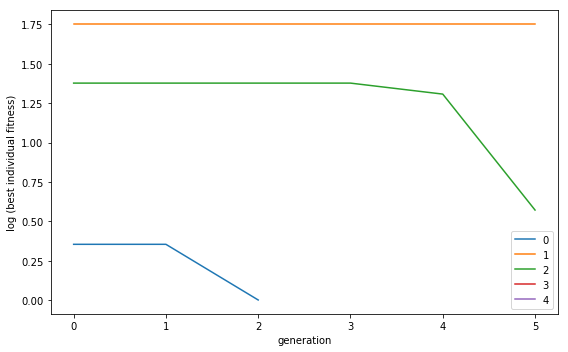

In [32]:
import matplotlib.pyplot as plt
import math


def log_plot(histories, figsize=(8,5), title=None):
    """ Dibuja el logaritmo del fitness de una 
    lista de ejecuciones."""
    plt.figure(figsize=figsize)
    plt.ylabel('log (best individual fitness)')
    plt.xlabel('generation')
    for h in histories:
        plt.plot([math.log(i.fitness + 1) for i in h])
    plt.legend([i for i in range(len(histories))])
    if title:
        plt.title(title)
    plt.tight_layout()    
    plt.show()

log_plot(sample_histories)

Figura 1: Prueba de representacion de progreso del fitness en escala logaritmica

## Índices SR, MBF y AES

Para las métricas SR y AES, un experimento se considera exitoso si se encuentra un individuo que alcanza un hit en todos los puntos de muestreo.

In [33]:
import numpy

def SR(histories):
    """ 
    Calcula el porcentaje de experimentos que 
    acaban con éxito. 
    Un experimento es considerado como exitoso 
    si encuentra un individuo que alcanza un hit
    en todos los puntos de muestreo.
    """
    exitos = filter(lambda h: h[-1].hitting, histories)
    return float(len(exitos)) / len(histories)


def AES(histories, GENERATION_SIZE):
    """
    Calcula el número medio de evaluaciones 
    y su desviación típica para aquellos 
    experimentos que fueron exitosos.
    Un experimento es considerado como exitoso 
    si encuentra un individuo que alcanza un hit
    en todos los puntos de muestreo.
    """ 
    exitos = filter(lambda h: h[-1].hitting, histories)  
    totals = [len(e) * GENERATION_SIZE for e in exitos]
    return np.mean(totals), np.std(totals)

def MBF(histories):
    """
    Calcula la media y la desciación típica 
    del fitness del mejor individuo encontrado
    """
    A = [h[-1].fitness for h in histories]
    return np.mean(A), np.std(A)

Y añado además una función que me facilita la presentación de resultados en forma de tabla:

In [34]:
import pandas as pd

pd.set_option('display.notebook_repr_html', True)

def _repr_latex_(self):
    return self.to_latex()

pd.DataFrame._repr_latex_ = _repr_latex_

def print_metrics(named_histories, config):
    """
    Dibuja de forma tabulada las métricas de 
    rendimiento de una lista de experimentos
    dados por el histórico de mejores individuos.
    """
    indexes=[]
    aes_means=[]
    aes_stds=[]
    mbf_means=[]
    mbf_stds=[]
    srs=[]
    for name,histories in named_histories:
        indexes = indexes + [name]
        aes = AES(histories, config['GENERATION_SIZE'])
        aes_means = aes_means + [aes[0]]
        aes_stds = aes_stds + [aes[1]]
        mbf = MBF(histories)
        mbf_means = mbf_means + [mbf[0]]
        mbf_stds = mbf_stds + [mbf[1]]        
        srs = srs + [SR(histories)]
    return pd.DataFrame(data={'AES mean': aes_means,
                              'AES std': aes_stds,
                              'MBF mean': mbf_means,
                              'MBF std': mbf_stds,
                              'SR' : srs}, 
                        index=indexes)


print_metrics([['Exp. 1', sample_histories],
               ['Exp. 2', sample_histories]], 
              default_config())

,AES mean,AES std,MBF mean,MBF std,SR
Exp. 1,166.666667,94.280904,1.110352,1.85771,0.6
Exp. 2,166.666667,94.280904,1.110352,1.85771,0.6


Figura 2. Tabla de prueba de representación de métricas

Añado además una funcionalidad que me permita ejecutar experimentos en paralelo:

In [35]:
from functools import partial
from multiprocessing import Pool
    
def i_live(f, D, config, i):
    return live(f, D, config)
        
def p_live(f, D, config, n):
    """
        Ejecuta en paralelo una batería 
        de experimentos.
    """    
    p = Pool()
    result = p.map(partial(i_live, f, D, config), 
                   range(n))
    p.close()    
    p.terminate()
    return result

# Los 7 problemas


In [2]:
def f_1(x): return 2 * x**3 + 5
def g_1(x): return 6 * x**2 

def f_2(x): return (x-1)/(x+1)
def g_2(x): return 2/((x+1)**2) 

def f_3(x): return ((x**2 + 1)*(x-1))/4
def g_3(x): return (3 * x**2)/4 - x/2 + 1

def f_4(x): return -exp(-(x**2) + 3)
def g_4(x): return 2 * x * exp(-(x**2) + 3) 

def f_5(x): return (exp(2*x) + exp(-6*x))/6
def g_5(x): return exp(2*x)/3 - exp(-6*x) 

def f_6(x): return x * log(1+x)
def g_6(x): return log(1+x) + x/(1+x) 

def f_7(x): return exp(x) * sin(x)
def g_7(x): return exp(x) * (sin(x) + cos(x)) 

problemas = [['Problema 1', f_1, g_1, [0,5]],
             ['Problema 2', f_2, g_2, [0,5]],
             ['Problema 3', f_3, g_3, [-2,2]],
             ['Problema 4', f_4, g_4, [0,3]],
             ['Problema 5', f_5, g_5, [0,2]],
             ['Problema 6', f_6, g_6, [0,5]],
             ['Problema 7', f_7, g_7, [-2,2]]]

# Justificación de la selección de parámetros

En primer lugar, vamos a evaluar el rendimiento del algoritmo **con los parámetros por defecto** en los 7 problemas:

In [37]:
def DEFAULT_CONFIG():
    config = default_config()
    results = []
    for nombre,f,_,D in problemas:
        results = results + [[nombre, 
                              p_live(f, D, config, 4)]]
    df = print_metrics(results, config)
    df.to_csv('data/DEFAULT_CONFIG.csv')
    return df


# DEFAULT_CONFIG()
pd.read_csv('data/DEFAULT_CONFIG.csv')

,Unnamed: 0,AES mean,AES std,MBF mean,MBF std,SR
0,Problema 1,NaN,NaN,142.068107,50.954791,0.0
1,Problema 2,NaN,NaN,3.531453,5.341082,0.0
2,Problema 3,NaN,NaN,4.192667,1.065582,0.0
3,Problema 4,NaN,NaN,20.811426,1.133662,0.0
4,Problema 5,NaN,NaN,3.831461,0.000000,0.0
5,Problema 6,NaN,NaN,2.745102,2.818062,0.0
6,Problema 7,NaN,NaN,4.983672,1.016625,0.0


Figura 3: Métricas del algoritmo en los 7 problemas con los parámetros por defecto

## MAX_WRAPS: aumentar vs no aumentar

In [80]:
def MAX_WRAPS_2():
    config = default_config(MAX_WRAPS=2)
    results = []
    for nombre,f,_,D in problemas:
        results = results + [[nombre, 
                              p_live(f, D, config, 4)]]
    df = print_metrics(results, config)
    df.to_csv('data/MAX_WRAPS_2.csv')
    return df

# MAX_WRAPS_2()
pd.read_csv('data/MAX_WRAPS_2.csv')

,Unnamed: 0,AES mean,AES std,MBF mean,MBF std,SR
0,Problema 1,NaN,NaN,146.376396,57.141162,0.0
1,Problema 2,NaN,NaN,NaN,NaN,0.0
2,Problema 3,NaN,NaN,NaN,NaN,0.0
3,Problema 4,NaN,NaN,24.993536,6.299949,0.0
4,Problema 5,NaN,NaN,7.612124,6.548301,0.0
5,Problema 6,10000.0,5800.0,0.540334,0.500558,0.5
6,Problema 7,NaN,NaN,5.570621,0.000000,0.0


Figura 4: Métricas del algoritmo en los 7 problemas con los parámetros por defecto excepto MAX_WRAPS=2


## CODON_SIZE: aumentar vs no aumentar

In [39]:
def CODON_SIZE_127():
    config = default_config(CODON_SIZE=127)
    results = []
    for nombre,f,_,D in problemas:
        results = results + [[nombre, 
                              p_live(f, D, config, 4)]]
    df = print_metrics(results, config)
    df.to_csv('data/CODON_SIZE_127.csv')
    return df

# CODON_SIZE_127()
pd.read_csv('data/CODON_SIZE_127.csv')

,Unnamed: 0,AES mean,AES std,MBF mean,MBF std,SR
0,Problema 1,19300.0,0.0,54.012639,31.969367,0.25
1,Problema 2,4100.0,0.0,0.264298,0.208685,0.25
2,Problema 3,NaN,NaN,NaN,NaN,0.00
3,Problema 4,NaN,NaN,22.865460,10.378308,0.00
4,Problema 5,NaN,NaN,15.342846,11.959379,0.00
5,Problema 6,NaN,NaN,0.872539,0.291543,0.00
6,Problema 7,NaN,NaN,5.222141,0.603586,0.00


Figura 5: Métricas del algoritmo en los 7 problemas con los parámetros por defecto excepto CODON_SIZE=127


## INITIAL_IND_LENGTH: aumentar vs no aumentar

In [40]:
def INITIAL_IND_LENGTH_50():
    config = default_config(INITIAL_IND_LENGTH=50)
    results = []
    for nombre,f,_,D in problemas:
        results = results + [[nombre, 
                              p_live(f, D, config, 4)]]
    df = print_metrics(results, config)
    df.to_csv('data/INITIAL_IND_LENGTH_50.csv')
    return df

# INITIAL_IND_LENGTH_50()
pd.read_csv('data/INITIAL_IND_LENGTH_50.csv')

,Unnamed: 0,AES mean,AES std,MBF mean,MBF std,SR
0,Problema 1,NaN,NaN,NaN,NaN,0.0
1,Problema 2,NaN,NaN,0.962100,0.848613,0.0
2,Problema 3,NaN,NaN,4.727849,0.463081,0.0
3,Problema 4,NaN,NaN,25.129750,6.875788,0.0
4,Problema 5,NaN,NaN,3.831461,0.000000,0.0
5,Problema 6,NaN,NaN,1.522788,0.288359,0.0
6,Problema 7,NaN,NaN,5.570621,0.000000,0.0


Figura 6: Métricas del algoritmo en los 7 problemas con los parámetros por defecto excepto INITIAL_IND_LENGTH=50



In [41]:
def INITIAL_IND_LENGTH_100():
    config = default_config(INITIAL_IND_LENGTH=100)
    results = []
    for nombre,f,_,D in problemas:
        results = results + [[nombre, 
                              p_live(f, D, config, 4)]]
    df = print_metrics(results, config)
    df.to_csv('data/INITIAL_IND_LENGTH_100.csv')
    return df

# INITIAL_IND_LENGTH_100()
pd.read_csv('data/INITIAL_IND_LENGTH_100.csv')

,Unnamed: 0,AES mean,AES std,MBF mean,MBF std,SR
0,Problema 1,NaN,NaN,NaN,NaN,0.00
1,Problema 2,19500.0,0.0,0.368584,0.251452,0.25
2,Problema 3,NaN,NaN,5.036758,0.071964,0.00
3,Problema 4,NaN,NaN,26.119421,9.021447,0.00
4,Problema 5,NaN,NaN,3.831461,0.000000,0.00
5,Problema 6,NaN,NaN,1.848851,1.150495,0.00
6,Problema 7,NaN,NaN,5.222141,0.603586,0.00


Figura 7: Métricas del algoritmo en los 7 problemas con los parámetros por defecto excepto INITIAL_IND_LENGTH=100


## EVAL_PENALTY: disminuir vs no disminuir

In [42]:
def EVAL_PENALTY_1000():
    config = default_config(EVAL_PENALTY=1e3)
    results = []
    for nombre,f,_,D in problemas:
        results = results + [[nombre, 
                              p_live(f, D, config, 4)]]
    df = print_metrics(results, config)
    df.to_csv('data/EVAL_PENALTY_1000.csv')
    return df

# EVAL_PENALTY_1000()
pd.read_csv('data/EVAL_PENALTY_1000.csv')

,Unnamed: 0,AES mean,AES std,MBF mean,MBF std,SR
0,Problema 1,NaN,NaN,122.430168,49.860774,0.00
1,Problema 2,10600.0,0.0,1.099773,1.618465,0.25
2,Problema 3,NaN,NaN,4.995209,0.000000,0.00
3,Problema 4,NaN,NaN,22.613858,5.190026,0.00
4,Problema 5,NaN,NaN,6.343392,4.350792,0.00
5,Problema 6,NaN,NaN,0.960322,0.196828,0.00
6,Problema 7,NaN,NaN,5.570621,0.000000,0.00


Figura 8: Métricas del algoritmo en los 7 problemas con EVAL_PENALTY=1000

## UNDECODABLE_PENALTY: disminuir vs no disminuir

In [43]:
def UNDECODABLE_PENALTY_1000():
    config = default_config(UNDECODABLE_PENALTY=1e3)
    results = []
    for nombre,f,_,D in problemas:
        results = results + [[nombre, 
                              p_live(f, D, config, 4)]]
    df = print_metrics(results, config)
    df.to_csv('data/UNDECODABLE_PENALTY_1000.csv')
    return df

# UNDECODABLE_PENALTY_1000()
pd.read_csv('data/UNDECODABLE_PENALTY_1000.csv')

,Unnamed: 0,AES mean,AES std,MBF mean,MBF std,SR
0,Problema 1,NaN,NaN,114.522158,38.286237,0.0
1,Problema 2,NaN,NaN,0.700936,0.155764,0.0
2,Problema 3,NaN,NaN,3.817615,1.189886,0.0
3,Problema 4,NaN,NaN,29.409299,6.392799,0.0
4,Problema 5,NaN,NaN,5.559838,2.993637,0.0
5,Problema 6,NaN,NaN,1.123896,0.931882,0.0
6,Problema 7,NaN,NaN,5.570621,0.000000,0.0


Figura 9: Métricas del algoritmo en los 7 problemas con UNDECODABLE_PENALTY=1000


## POPULATION_SIZE: aumentar vs no aumentar

In [44]:
def POPULATION_SIZE_200():
    config = default_config(POPULATION_SIZE=200)
    results = []
    for nombre,f,_,D in problemas:
        results = results + [[nombre, 
                              p_live(f, D, config, 4)]]  
    df = print_metrics(results, config)
    df.to_csv('data/POPULATION_SIZE_200.csv')
    return df

# POPULATION_SIZE_200()
pd.read_csv('data/POPULATION_SIZE_200.csv')

,Unnamed: 0,AES mean,AES std,MBF mean,MBF std,SR
0,Problema 1,NaN,NaN,139.726726,62.983872,0.0
1,Problema 2,NaN,NaN,0.411865,0.199219,0.0
2,Problema 3,NaN,NaN,5.114804,0.207145,0.0
3,Problema 4,NaN,NaN,30.240542,19.966994,0.0
4,Problema 5,NaN,NaN,3.831461,0.000000,0.0
5,Problema 6,NaN,NaN,1.458915,0.665758,0.0
6,Problema 7,NaN,NaN,5.570621,0.000000,0.0


Figura 10: Métricas del algoritmo en los 7 problemas con POPULATION_SIZE=200


## GENERATION_SIZE: aumentar vs no aumentar

In [45]:
def GENERATION_SIZE_200():
    config = default_config(GENERATION_SIZE=200)
    results = []
    for nombre,f,_,D in problemas:
        results = results + [[nombre, 
                              p_live(f, D, config, 4)]]
    df = print_metrics(results, config)
    df.to_csv('data/GENERATION_SIZE_200.csv')
    return df

# GENERATION_SIZE_200()
pd.read_csv('data/GENERATION_SIZE_200.csv')

,Unnamed: 0,AES mean,AES std,MBF mean,MBF std,SR
0,Problema 1,NaN,NaN,91.914817,24.080218,0.0
1,Problema 2,NaN,NaN,0.415805,0.195200,0.0
2,Problema 3,NaN,NaN,4.995209,0.000000,0.0
3,Problema 4,NaN,NaN,24.821044,9.733324,0.0
4,Problema 5,NaN,NaN,3.831461,0.000000,0.0
5,Problema 6,NaN,NaN,1.073364,0.039292,0.0
6,Problema 7,NaN,NaN,4.973429,1.034368,0.0


Figura 11: Métricas del algoritmo en los 7 problemas con GENERATION_SIZE=200


## MUTATION_PROBABILITY: aumentar vs no aumentar


In [75]:
def MUTATION_PROBABILITY_0_25():
    config = default_config(MUTATION_PROBABILITY=0.25)
    results = []
    for nombre,f,_,D in problemas:
        results = results + [[nombre, 
                              p_live(f, D, config, 4)]]
    df = print_metrics(results, config)
    df.to_csv('data/MUTATION_PROBABILITY_0_25.csv')
    return df

# MUTATION_PROBABILITY_0_25()
pd.read_csv('data/MUTATION_PROBABILITY_0_25.csv')

,Unnamed: 0,AES mean,AES std,MBF mean,MBF std,SR
0,Problema 1,NaN,NaN,172.029752,11.676577,0.0
1,Problema 2,NaN,NaN,1.117145,0.672654,0.0
2,Problema 3,NaN,NaN,4.995209,0.000000,0.0
3,Problema 4,NaN,NaN,44.875424,5.542221,0.0
4,Problema 5,NaN,NaN,7.612124,6.548301,0.0
5,Problema 6,NaN,NaN,3.947566,2.772900,0.0
6,Problema 7,NaN,NaN,5.570621,0.000000,0.0


Figura 12: Métricas del algoritmo en los 7 problemas con MUTATION_PROBABILITY=0.25


## CROSSOVER_PROBABILITY: aumentar vs no aumentar

In [77]:
def CROSSOVER_PROBABILITY_0_25():
    config = default_config(CROSSOVER_PROBABILITY=0.25)
    results = []
    for nombre,f,_,D in problemas:
        results = results + [[nombre, 
                              p_live(f, D, config, 4)]]
    df = print_metrics(results, config)
    df.to_csv('data/CROSSOVER_PROBABILITY_0_25.csv')
    return df

# CROSSOVER_PROBABILITY_0_25()
pd.read_csv('data/CROSSOVER_PROBABILITY_0_25.csv')

,Unnamed: 0,AES mean,AES std,MBF mean,MBF std,SR
0,Problema 1,NaN,NaN,229.630645,204.948215,0.0
1,Problema 2,NaN,NaN,NaN,NaN,0.0
2,Problema 3,NaN,NaN,5.838441,1.460520,0.0
3,Problema 4,NaN,NaN,21.414234,8.668674,0.0
4,Problema 5,NaN,NaN,3.831461,0.000000,0.0
5,Problema 6,NaN,NaN,2.522542,2.949525,0.0
6,Problema 7,NaN,NaN,5.570621,0.000000,0.0


Figura 13: Métricas del algoritmo en los 7 problemas con CROSSOVER_PROBABILITY=0.25


## WITHIN_USED: True vs False

In [48]:
def WITHIN_USED_False():
    config = default_config(WITHIN_USED=False)
    results = []
    for nombre,f,_,D in problemas:
        results = results + [[nombre, 
                              p_live(f, D, config, 4)]]
    df = print_metrics(results, config)
    df.to_csv('data/WITHIN_USED_False.csv')
    return df

# WITHIN_USED_False()
pd.read_csv('data/WITHIN_USED_False.csv')

,Unnamed: 0,AES mean,AES std,MBF mean,MBF std,SR
0,Problema 1,NaN,NaN,NaN,NaN,0.0
1,Problema 2,NaN,NaN,0.920768,0.190380,0.0
2,Problema 3,NaN,NaN,5.546323,0.954558,0.0
3,Problema 4,NaN,NaN,31.060151,14.587716,0.0
4,Problema 5,NaN,NaN,3.831461,0.000000,0.0
5,Problema 6,NaN,NaN,3.941515,2.684870,0.0
6,Problema 7,NaN,NaN,5.052879,0.896756,0.0


Figura 14: Métricas del algoritmo en los 7 problemas con WITHIN_USED=False

## TOURNAMENT_SIZE: aumentar vs no aumentar¶

In [49]:
def TOURNAMENT_SIZE_5():
    config = default_config(TOURNAMENT_SIZE=5)
    results = []
    for nombre,f,_,D in problemas:
        results = results + [[nombre, 
                              p_live(f, D, config, 4)]]
    df = print_metrics(results, config)
    df.to_csv('data/TOURNAMENT_SIZE_5.csv')
    return df

# TOURNAMENT_SIZE_5()
pd.read_csv('data/TOURNAMENT_SIZE_5.csv')

,Unnamed: 0,AES mean,AES std,MBF mean,MBF std,SR
0,Problema 1,NaN,NaN,NaN,NaN,0.0
1,Problema 2,4500.0,2000.0,0.112864,0.055493,0.5
2,Problema 3,NaN,NaN,NaN,NaN,0.0
3,Problema 4,NaN,NaN,NaN,NaN,0.0
4,Problema 5,NaN,NaN,11.534760,7.705916,0.0
5,Problema 6,NaN,NaN,0.617612,0.448030,0.0
6,Problema 7,NaN,NaN,5.570621,0.000000,0.0


Figura 15: Métricas del algoritmo en los 7 problemas con TOURNAMENT_SIZE=5

## ELITE_SIZE: aumentar vs no aumentar¶

In [50]:
def ELITE_SIZE_5():
    config = default_config(ELITE_SIZE=5)
    results = []
    for nombre,f,_,D in problemas:
        results = results + [[nombre, 
                              p_live(f, D, config, 4)]]
    df = print_metrics(results, config)
    df.to_csv('data/ELITE_SIZE_5.csv')
    return df

# ELITE_SIZE_5()
pd.read_csv('data/ELITE_SIZE_5.csv')

,Unnamed: 0,AES mean,AES std,MBF mean,MBF std,SR
0,Problema 1,NaN,NaN,100.095912,59.453245,0.0
1,Problema 2,NaN,NaN,0.794103,0.825822,0.0
2,Problema 3,NaN,NaN,6.968468,2.326186,0.0
3,Problema 4,NaN,NaN,25.735883,8.942756,0.0
4,Problema 5,NaN,NaN,3.831461,0.000000,0.0
5,Problema 6,NaN,NaN,1.102890,0.448803,0.0
6,Problema 7,NaN,NaN,3.517940,2.103524,0.0


Figura 16: Métricas del algoritmo en los 7 problemas con ELITE_SIZE=5


## Comparación de resultados y selección final de parámetros

Observando los resultados de los experimentos parciales anteriores (consistentes en modificar un sólo parámetro cada vez), podemos constatar:


In [83]:
names = ['DEFAULT_CONFIG.csv',
         'CODON_SIZE_127.csv',
         'CROSSOVER_PROBABILITY_0_25.csv',
         'ELITE_SIZE_5.csv',
         'EVAL_PENALTY_1000.csv',
         'GENERATION_SIZE_200.csv',
         'INITIAL_IND_LENGTH_100.csv',
         'INITIAL_IND_LENGTH_50.csv',
         'MAX_WRAPS_2.csv',
         'MUTATION_PROBABILITY_0_25.csv',
         'POPULATION_SIZE_200.csv',
         'TOURNAMENT_SIZE_5.csv',
         'UNDECODABLE_PENALTY_1000.csv',
         'WITHIN_USED_False.csv']

mbf_means=[]
mbf_stds=[]
srs_means=[]
for name in names:
    df = pd.read_csv('data/' + name)
    mbf_means = mbf_means + [df['MBF mean'].mean()]
    mbf_stds = mbf_stds + [df['MBF std'].mean()]
    srs_means = srs_means + [df['SR'].mean()]

pd.DataFrame(data={'MBF means': mbf_means,
                   'MBF stds': mbf_stds,
                   'SR means': srs_means},
             index=names)

,MBF means,MBF stds,SR means
DEFAULT_CONFIG.csv,26.023413,8.904258,0.000000
CODON_SIZE_127.csv,16.429987,9.235145,0.071429
CROSSOVER_PROBABILITY_0_25.csv,44.801324,36.337823,0.000000
ELITE_SIZE_5.csv,20.292380,10.585762,0.000000
EVAL_PENALTY_1000.csv,23.430478,8.745269,0.035714
GENERATION_SIZE_200.csv,18.860733,5.011772,0.000000
INITIAL_IND_LENGTH_100.csv,7.071202,1.849824,0.035714
INITIAL_IND_LENGTH_50.csv,6.957428,1.412640,0.000000
MAX_WRAPS_2.csv,37.018602,14.097994,0.071429
MUTATION_PROBABILITY_0_25.csv,34.306834,3.887522,0.000000


Figura 17: Comparativa de experimentos parciales

La tabla anterior nos conduce a pensar que las siguientes modificaciones en la configuración por defecto **conducen a mejores resultados**:

- **incrementar CODON_SIZE a 127 (mejora la SR)**
- **aumentar la ELITE_SIZE a 5 (mejora la MBF)**
- **disminuir EVAL_PENALTY a 1000 (mejora la MBF y la SR)**
- **incrementar GENERATION_SIZE a 200 (mejora la MBF)**
- **incrementar INITIAL_IND_LENGTH a 100 (mejora la MBF y la SR)**
- **establecer MAX_WRAPS a 2 (mejora la SR)**
- **incrementar TOURNAMENT_SIZE a 5 (mejora la MBF y la SR)**
- **disminuir UNDECODABLE_PENALTY a 1000 (mejora la MBF)**
- **establecer WITHIN_USED a False (mejora la MBF)**

Las demás modificacines que hemos probado no parecen ofrecer, de forma aislada, mejores resultados que los de la configuración por defecto.

Con estos datos podemos definir la configuración "óptima" con la que continuaremos el resto de experimentos de esta práctica.

In [104]:
FINAL_CONFIG = default_config(MAX_WRAPS=2,
                              CODON_SIZE=127,
                              INITIAL_IND_LENGTH=100,
                              EVAL_PENALTY=1000,
                              UNDECODABLE_PENALTY=1000,
                              GENERATION_SIZE=200,
                              MAX_GENERATIONS=1000,
                              TOURNAMENT_SIZE=5,
                              ELITE_SIZE=5,
                              WITHIN_USED=False)

# Ejecución con la configuración "óptima" en los 7 problemas

In [ ]:
import pickle


def run_full(config):
    results = []
    for nombre, f, _, D in problemas:
        print nombre
        results = results + [[nombre, p_live(f, D, config, 4)]]
    with open('data/full_experiment.pkl', 'wb') as output:
        pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)
    df = print_metrics(results, config)
    df.to_csv('data/full_experiment.csv')


# run_full(FINAL_CONFIG)

Problema 1
Problema 2
Problema 3


Como esta ejecución del experimento es bastante pesada guardo los resultados en **'data/full_experiment.pkl'**, de manera que puedo trabajar con ellos sin tener que re-ejecutar todo.

Con estos resultados podemos ver los **plots de progreso para cada problema**. Nótese que normalmente se analizan los plots de progreso para determinar si una u otra configuración del algoritmo ofrece mejores resultados a no. Así lo he hecho en las secciones anteriores de determinación de mejores parámetros, aunque no lo haya adjuntado en esta práctica. Sin embargo, **muestro estos plots ahora en esta sección, sencillamente por curiosidad sobre el comportamiento del algoritmo con la configuración final en cada uno de los 7 problemas**.

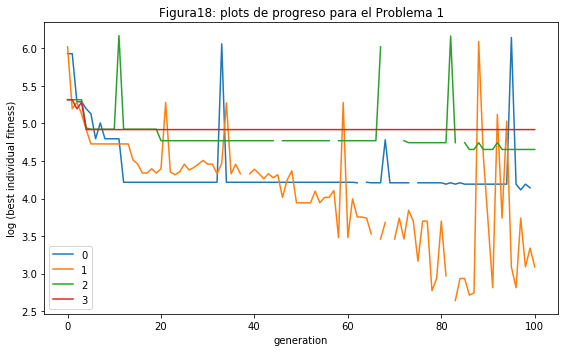

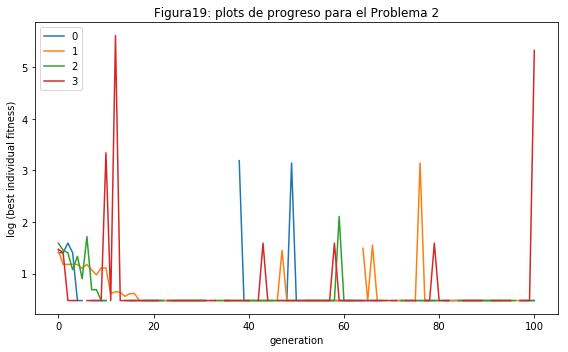

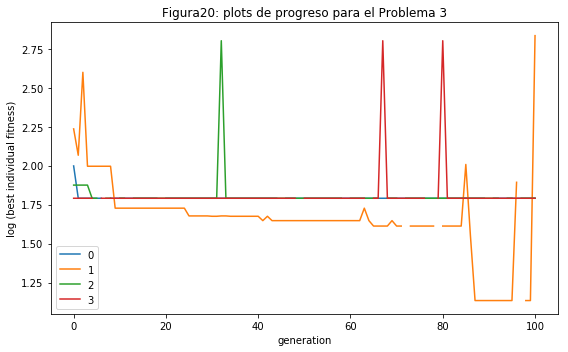

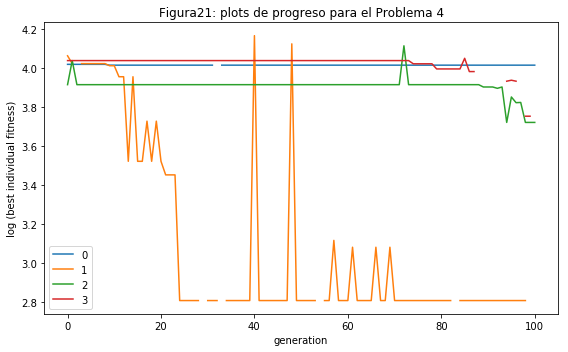

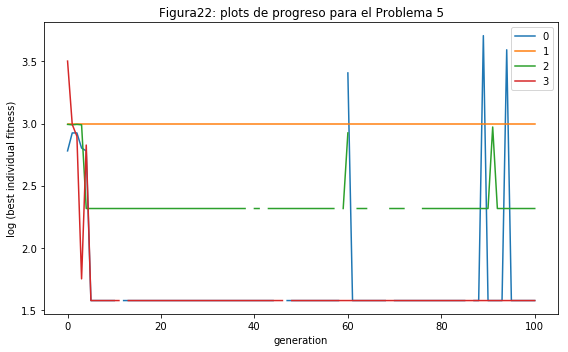

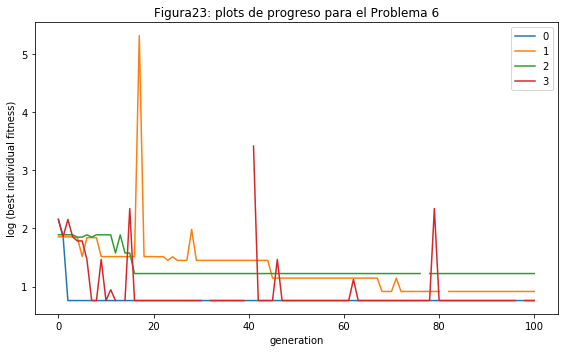

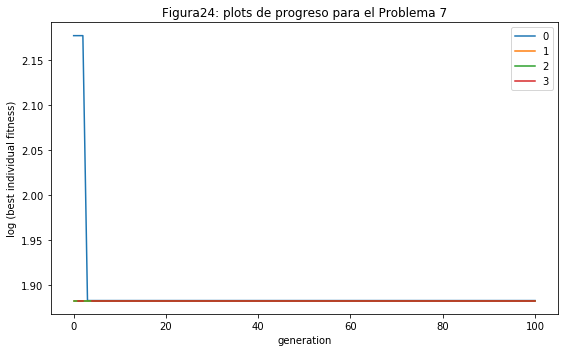

In [101]:
def get_full():
    with open('data/full_experiment.pkl', 'rb') as input:
        return pickle.load(input)

i=18
for name, histories in get_full():
    log_plot(histories,title='Figura' + str(i) + \
             ': plots de progreso para el ' + name)
    i += 1

Y la tabla de métricas resultantes para cada problema:

In [102]:
pd.read_csv('data/full_experiment.csv')

,Unnamed: 0,AES mean,AES std,MBF mean,MBF std,SR
0,Problema 1,NaN,NaN,NaN,NaN,0.0
1,Problema 2,NaN,NaN,51.436812,88.032878,0.0
2,Problema 3,NaN,NaN,7.752892,4.776448,0.0
3,Problema 4,NaN,NaN,NaN,NaN,0.0
4,Problema 5,NaN,NaN,8.938523,6.174861,0.0
5,Problema 6,NaN,NaN,1.543259,0.516469,0.0
6,Problema 7,NaN,NaN,5.570621,0.000000,0.0


Figura 25: Resultados del experimento con la configuración "óptima" para todas los problemas.

# Soluciones encontradas

Cada uno de los 7 problemas anteriores se ha atacado con 4 ejecuciones del algoritmo, compartiendo la configuración que se encontró en el punto anterior.

Entonces, para determinar la mejor solución encontrada para cada problema nos quedaremos con el mejor individuo de la mejor ejecución de las 4 por problema. Este individuo, para cada problema, podremos finalmente representarlo junto con la derivada que se supone que aproxima.

Aquí tenemos los mejores individuos encontrados para cada problema:

In [ ]:
best_found = {}
for name, histories in get_full():
    best = histories[0][-1]
    for history in histories[1:]:
        best = history[-1] if history[-1].fitness < best.fitness else best
    best_found[name] = best.fhenotype

best_found

# Representación de las soluciones encontradas y las esperadas

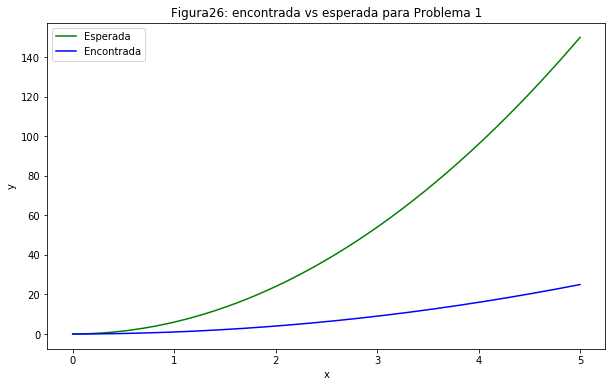

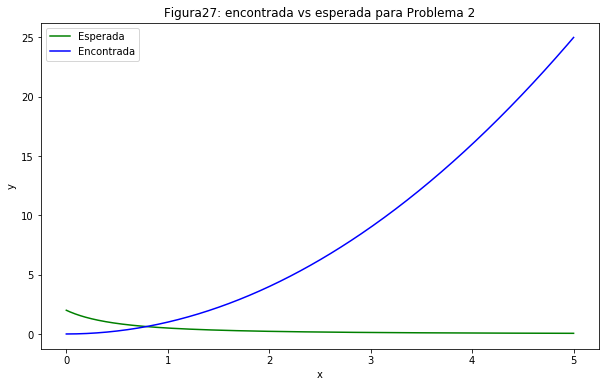

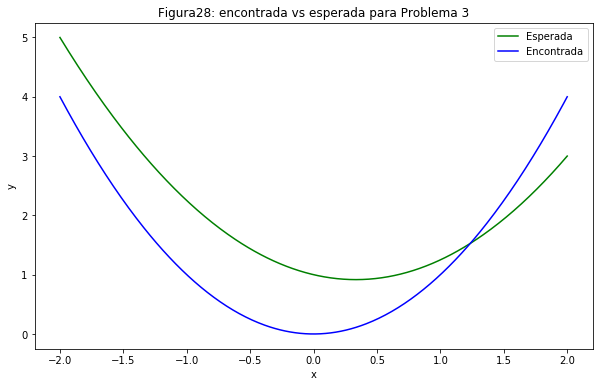

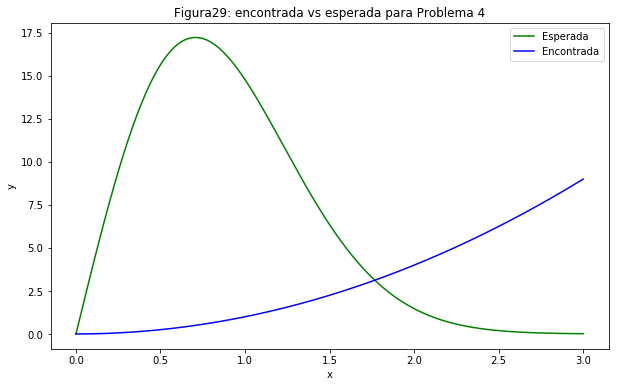

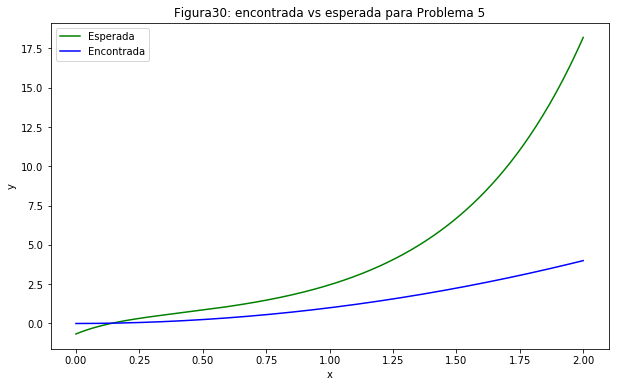

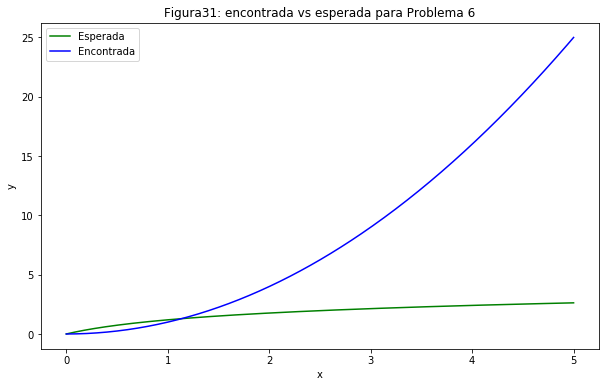

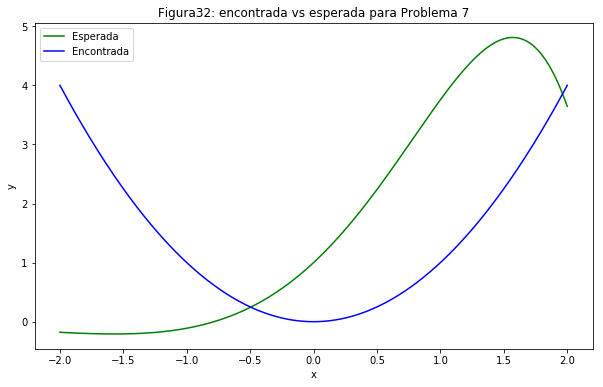

In [14]:
import inspect 
def src(f):
    return str(inspect.getsourcelines(f)[0][0] \
               .split('return ')[1].split('\n')[0])
    
src(f_1)

i=26
for nombre, _, g, D in problemas:
    t = np.linspace(D[0],D[1],400)
    fen = eval('lambda x: x**2')
    plt.figure(figsize=(10,6))
    plt.plot(t,[g(x) for x in t],'g', 
             label='Esperada: ' + src(g))
    plt.plot(t,[fen(x) for x in t],'b', 
             label='Encontrada: ' + best_found[nombre])
    plt.title('Figura' + str(i) + ': encontrada vs esperada para ' + nombre)
    plt.legend()    
    plt.ylabel('y')
    plt.xlabel('x')
    plt.show()
    i += 1
    
    

In [27]:
import inspect 
def src(f):
    return str(inspect.getsourcelines(f)[0][0] \
               .split('return ')[1].split('\n')[0])
    
src(f_1)


'Figura 1: encontrada vs esperada para ffff'